Multimedia Security and Privacy  
Lea Heiniger  
22.03.2023   
  
  # TP1: Basic Image Processing  
  

In [13]:
import numpy as np
import cv2
import skimage
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import skimage.metrics as metric
from scipy import signal
from skimage.measure import block_reduce
from os import listdir
from os.path import isfile, join


## 1 Introduction

We start by creating two functions that will be usefull during this TP. One to display images and one to display histograms.

In [14]:
def display_img(images, labels, rows, cols, cmap = None) :
    ''' function that allows us to display one or more images '''

    axes = []
    fig = plt.figure()

    for i in range(rows * cols) :
        axes.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(images[i], cmap)
        plt.title(labels[i])
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def display_histo(histograms, tabs, labels, rows, cols) :
    ''' function that allows us to display one or more histogram '''

    _, axs = plt.subplots(rows, cols, figsize=(20,5))

    for i in range(rows * cols) :
        axs[i].plot(histograms[i], tabs[i])
        axs[i].set_title(labels[i])
    plt.show()

Using those functions we will load an image and display it and some information about it (its dimensions and the histograms of its RGB channels)

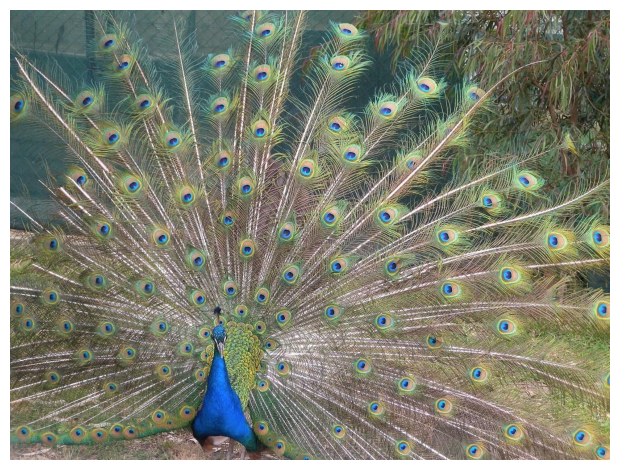

Height :  792
Width :  1056
Channels :  3


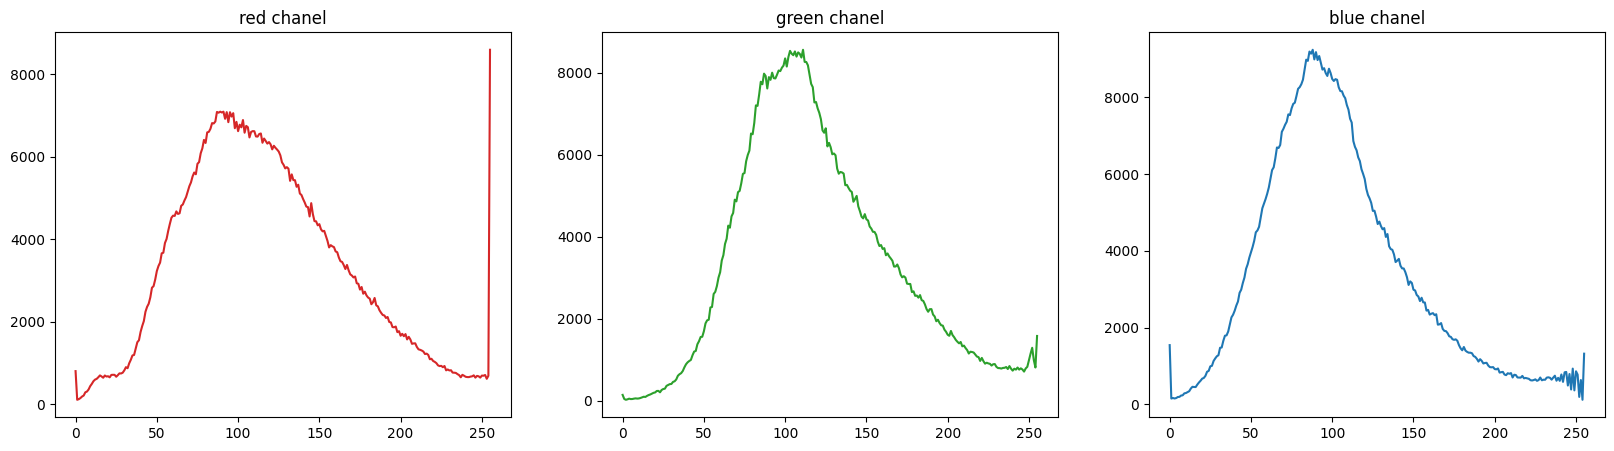

In [15]:
img = plt.imread("peacock.jpg")
display_img([img],[""],1,1,)

h,w,c = img.shape
print("Height : ",h)
print("Width : ",w)
print("Channels : ",c)

 

display_histo(histograms, tabs, labels, 1, 3)

Then we display the image in grayscale and compute its mean and variance.

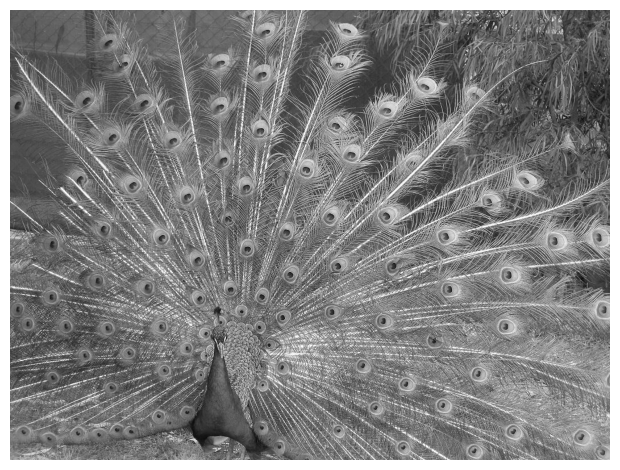

Global mean :      118.79164394895929
Global variance :  2144.2387572253087


In [16]:
grayimg = cv2.imread("peacock.jpg",0)
display_img([grayimg],[""],1,1,'gray')

globMean = grayimg.mean()
globVar = grayimg.var()

print("Global mean :     ",globMean)
print("Global variance : ",globVar)

Always on the same image we compute the local mean and variance for different block sizes and display the result.

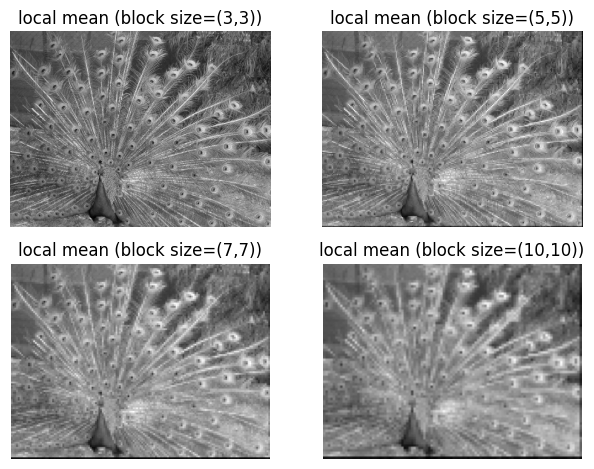

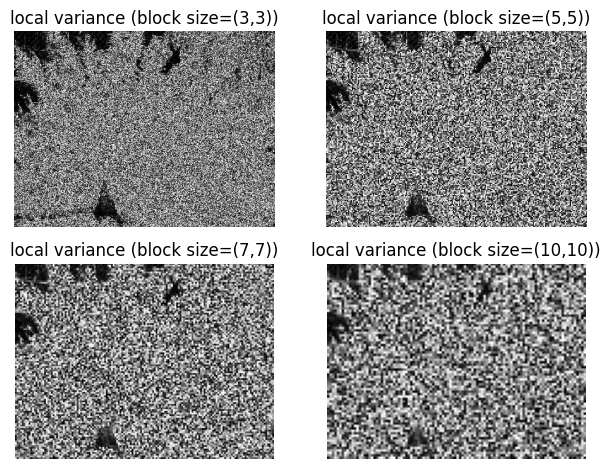

In [17]:
images = []
labels = []
for i in [3,5,7,10] :
    locMean = block_reduce(grayimg, block_size = (i,i), func = np.mean)
    locMean = locMean.astype(np.uint8)
    images.append(locMean)
    labels.append("local mean (block size=("+str(i)+","+str(i)+"))")

display_img(images,labels,2,2,'gray')

images = []
labels = []
for i in [3,5,7,10] :
    locVar = block_reduce(grayimg, block_size = (i,i), func = np.var)
    locVar = locVar.astype(np.uint8)
    images.append(locVar)
    labels.append("local variance (block size=("+str(i)+","+str(i)+"))")

display_img(images,labels,2,2,'gray')

## 2 Noise

We start by creating functions that add different types of noise (Gaussian and salt and pepper) to images. We also implement the MSE and PSNR metrics.

In [18]:
# Additive White Gaussian Noise

def gaussian_noise(N, M , mu, sigma) :
    ''' function that generate a N by M array of Gaussian noise with parameters mu and sigma '''

    return np.asarray([[np.random.normal(mu, sigma) for i in range(M)] for j in range(N)])

# Salt and pepper Noise

def salt_pepper_noise(X, p, q) :
    ''' function that generate salt and pepper noise with parameters p and q on an image X '''     

    if (p+q >= 1) :
        raise ValueError("p+q must be smaller than 1")
    
    s_min = np.min(X)
    s_max = np.max(X)
    N, M = X.shape

    Y = np.copy(X)

    for i in range(N) :
        for j in range(M) :
            
            r = np.random.rand()

            if r <= p :
                Y[i][j] = s_min

            elif r <= p+q :
                Y[i][j] = s_max   

    return Y


# Metrics

def MSE(X, Y) :
    ''' function that computes the Mean Squared Error between X and Y '''
    if X.shape != Y.shape :
        return 0 
    else:
        return np.sum([np.sum([(X[i, j]- Y[i, j])**2 for j in range(X.shape[1])]) for i in range(X.shape[0])]) / (X.shape[0]*X.shape[1])
    
def PSNR(X, Y) :
    ''' function that computes the Peak Signal to Noise Ratio between X and Y '''

    mse = MSE(X,Y)
    if mse == 0:
        return 0
    else:
        return 10 * np.log10(255**2/mse)
    
def PSNR2(X, Y):
    ''' function that computes the PSNR expressed as a function of the noise variance '''
    a = 255
    sigma = np.sqrt(MSE(X, Y))
    return 10 * np.log10((a**2)/(sigma**2))

To test the MSE metric we load twice the same image but once with 8 bits per pixels and once with only 1 bit per pixels.

In [48]:
X = cv2.imread("peacock.jpg",0) 
Y = skimage.img_as_float(cv2.imread("peacock.jpg",0)) 

mse = MSE(X, Y)

print("The MSE between the two images : ", mse)

The MSE between the two images :  16128.447786022514


We have a very high MSE due to the fact that the images are completely different. Since in the first image there are 256 values for a bit and in the second image there is only two possible values, it is parobable that almoste every pixels are differents.

We load an image and apply different levels of additive gaussian white noise.

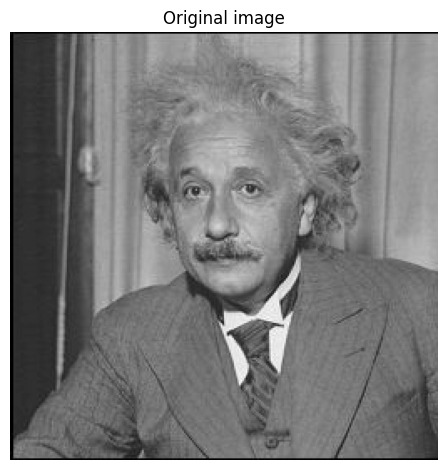

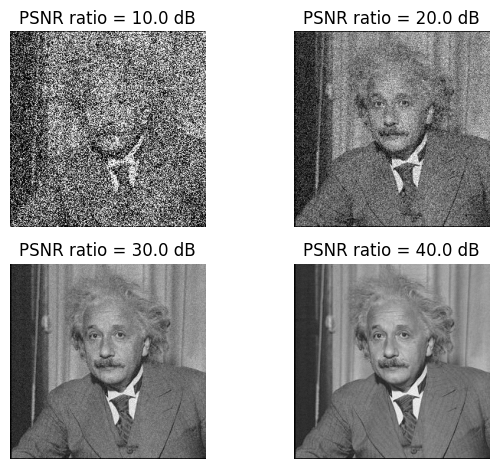

In [20]:
img = np.float32(cv2.imread("dct_db/einstein.tif",0))
display_img([img],["Original image"],1,1,'gray')

N, M = img.shape

imagesG = []
labelsG = []

for sigma in [100,27,8,2.5]:
    
    noise = gaussian_noise(N, M , 0, sigma)
    noisy_img = np.asarray([[max(min(255,img[j,i] + noise[j,i]),0) for i in range(M)] for j in range(N)])
    imagesG.append(noisy_img)
    psnr2 = np.round(PSNR2(noisy_img, img))
    labelsG.append("PSNR ratio = "+str(psnr2)+" dB")

display_img(imagesG,labelsG,2,2,'gray')

We do the same with salt and peper noise.

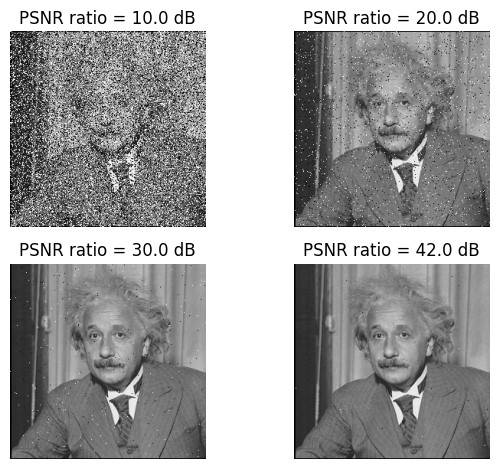

In [21]:
imagesP = []
labelsP = []

for p in [0.19,0.019,0.0020,0.00016]:
    noisy_img = salt_pepper_noise(img, p, p)
    imagesP.append(noisy_img)
    psnr2 = np.round(PSNR2(noisy_img, img))
    labelsP.append("PSNR ratio = "+str(psnr2)+" dB")
    
display_img(imagesP,labelsP,2,2,'gray')

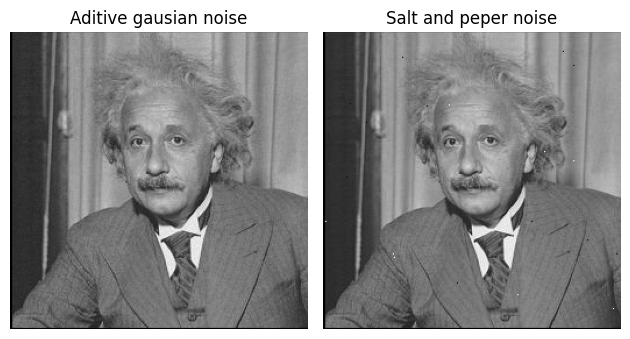

In [22]:
display_img([imagesG[-1], imagesP[-1]],["Aditive gausian noise", "Salt and peper noise"],1,2,'gray')

We can see that the higher the PSNR the less noise we have.
Comparing the images obtained with the two types of noise for a PSNR of 40 dB, we can see that the additive gaussian white noise is less visible to the human eye (we hardly see the difference with the original) than the salt and peper noise.

## 3 Identification

We start by implementing a function to load the 200 images in the folder and a function that computes perceptual hashes.

In [23]:
def load_images(folder):
    ''' function that loads in grayscale the images in a folder '''
    fileNames = [f for f in listdir(folder) if isfile(join(folder, f))]
    return [np.float32(cv2.imread(folder + "/" + fileName, 0)) for fileName in fileNames]

def perceptual_hash(img):
    ''' function that computes the perceptual hash of an image '''
    globMean = img.mean()
    localMean = block_reduce(img, block_size=(32, 32), func = np.mean)
    binaryV = np.asarray([1 if localMean_>globMean else -1 for localMean_ in localMean.flatten()])
    
    return binaryV

In [27]:
images = load_images("dct_db")
percepHashes = [perceptual_hash(img) for img in images]

print("Number of unique hashes on the total number : ", len(np.unique(percepHashes, axis=1)),"/",len(percepHashes))

Number of unique hashes on the total number :  200 / 200


As we want the perceptual hash is unique for every image.

Then we create a noizy version of each image (with AGWN) and we compute the probability of error on the perceptual hashes intra and inter class.

In [40]:
def hamming_distance(s1,s2):
    ''' function that computes the hamming distance and probability of error between twoo binary vectors '''
    h = [s1[i] == s2[i] for i in range(s1.shape[0])].count(False)
    Pb = h/s1.shape[0]
    return h, Pb

def addAGWN(images, mu=0, sigma=4.5, p=0.1, q=0.1):
    ''' function that computes noisy images with PSNR=35DB '''
    noisy_images = []
    for img in images :
        noise = gaussian_noise(img.shape[0], img.shape[1], 0, sigma)
        noisy_img = np.asarray([[max(min(255,img[j,i] + noise[j,i]),0) for i in range(img.shape[1])] for j in range(img.shape[0])])
        noisy_images.append(noisy_img)
    return noisy_images


            
def Pb_inter(Zp, L):
    return [Zp[i,j]/L for i in range(Zp.shape[0]) for j in range(i+1,Zp.shape[0])]

def Pb_intra(Z, L):
    return [Z[i,i]/L for i in range(Z.shape[0])]


In [45]:
originalHashes = np.asarray([perceptual_hash(img) for img in images]).transpose()

noisy_images = addAGWN(images)
noisyHashes = np.asarray([perceptual_hash(img) for img in noisy_images]).transpose()


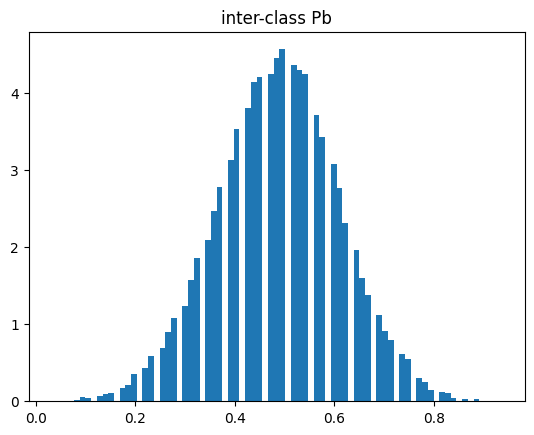

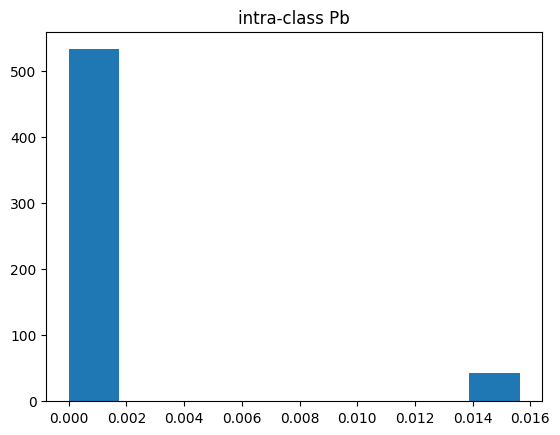

In [47]:
L = 64
Z = np.matmul(originalHashes.transpose(),noisyHashes)
Z = np.divide((Z - L),-2)
Zp = np.matmul(originalHashes.transpose(),originalHashes)
Zp = np.divide((Zp - L),-2)


interPb = Pb_inter(Zp, L)
intraPb = Pb_intra(Z,L)

plt.hist(interPb, bins ="auto",label= "inter class",density=True)
plt.title("inter-class Pb")
plt.show()

plt.hist(intraPb, bins ="auto", density=True)
plt.title("intra-class Pb")
plt.show()

We can see that the error of probability inter class is folowing a gaussian distribution. And the 